In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')


#### Training set has 48 columns, while test set has 24 columns. The last 24 training columns are missing in the test data set!
- The first column (fecha_dato) is the date column. The second column (ncodpers) is the customer_id. 
- The third column (ind_empleado) is the status of employment; The fourth column (pais_residencia) is country of residency
- The fifth column (sexo) is sex; The six column (age); The seventh column (fecha_alta) is the date of join
- The eightth column (ind_nuevo) is new costumer; The ninth column (antiguedad) is antiquity (Senority 古老,古代)

In [74]:
# read in data first
#import os, math, time

#os.chdir(r"J:\Tutorial\Kaggle Competitions\Santander")

train = pd.read_csv("../../input/train_ver2.csv")#, nrows=200000)
test = pd.read_csv('../../input/test_ver2.csv')#, nrows=200000)

# read in data first
#train = pd.read_csv("data/train_ver2.csv", nrows=200000)
#test = pd.read_csv('data/test_ver2.csv', nrows=200000)
#print(train.info())
#print(test.info())
#print(train.head())
#print(test.head())

# sepatate last 24 columns from training dataset
trainX = train.iloc[:,:24]
trainZ = train.iloc[:,24:]

# combine train and test dataset
combined = pd.concat([trainX, test], ignore_index=True)

# here 'age', 'renta' and 'antiguedad' are type of object, we need to convert it to numeric
# test's 'renta' is an object, so the final combined 'renta' is also type of object
combined['age']        = pd.to_numeric(combined['age'], errors='coerce')
combined['renta']      = pd.to_numeric(combined['renta'], errors='coerce')
combined['antiguedad'] = pd.to_numeric(combined['antiguedad'], errors='coerce')

# need to convert 'fecha_dato' and 'fecha_alta' to datetime
combined['fecha_dato'] = pd.to_datetime(combined['fecha_dato'], format='%Y-%m-%d')
combined['fecha_alta'] = pd.to_datetime(combined['fecha_alta'], format='%Y-%m-%d')
print(combined['fecha_dato'].unique())




['2015-01-28T00:00:00.000000000' '2015-02-28T00:00:00.000000000'
 '2015-03-28T00:00:00.000000000' '2015-04-28T00:00:00.000000000'
 '2015-05-28T00:00:00.000000000' '2015-06-28T00:00:00.000000000'
 '2015-07-28T00:00:00.000000000' '2015-08-28T00:00:00.000000000'
 '2015-09-28T00:00:00.000000000' '2015-10-28T00:00:00.000000000'
 '2015-11-28T00:00:00.000000000' '2015-12-28T00:00:00.000000000'
 '2016-01-28T00:00:00.000000000' '2016-02-28T00:00:00.000000000'
 '2016-03-28T00:00:00.000000000' '2016-04-28T00:00:00.000000000'
 '2016-05-28T00:00:00.000000000' '2016-06-28T00:00:00.000000000']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14576924 entries, 0 to 14576923
Data columns (total 11 columns):
fecha_dato               datetime64[ns]
ncodpers                 int64
age                      float64
fecha_alta               datetime64[ns]
ind_nuevo                float64
antiguedad               float64
indrel                   float64
tipodom                  float64
cod_prov                 float64
ind_actividad_cliente    float64
renta                    float64
dtypes: datetime64[ns](2), float64(8), int64(1)
memory usage: 1.2 GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14576924 entries, 0 to 14576923
Data columns (total 13 columns):
ind_empleado       object
pais_residencia    object
sexo               object
ult_fec_cli_1t     object
indrel_1mes        object
tiprel_1mes        object
indresi            object
indext             object
conyuemp           object
canal_entrada      object
indfall            object
nomprov            object
segmento 

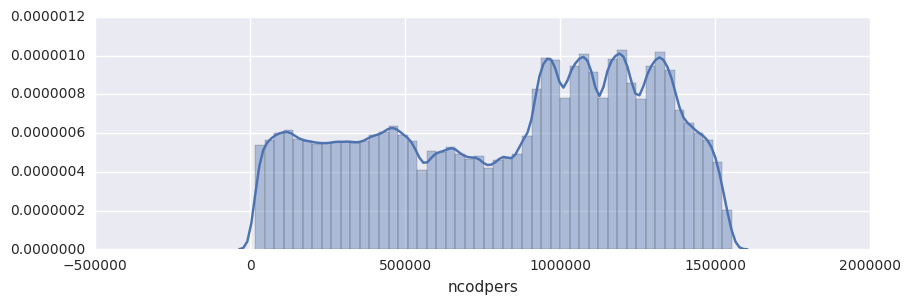

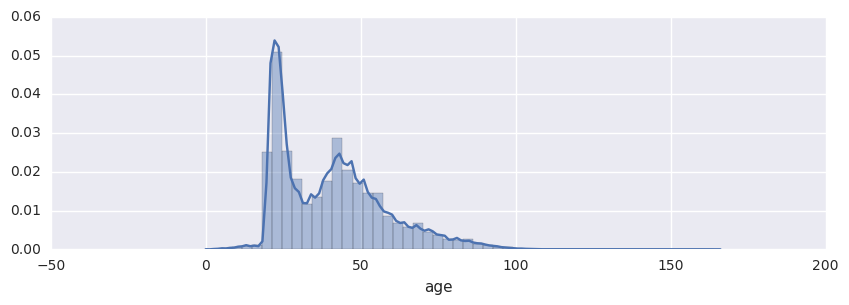

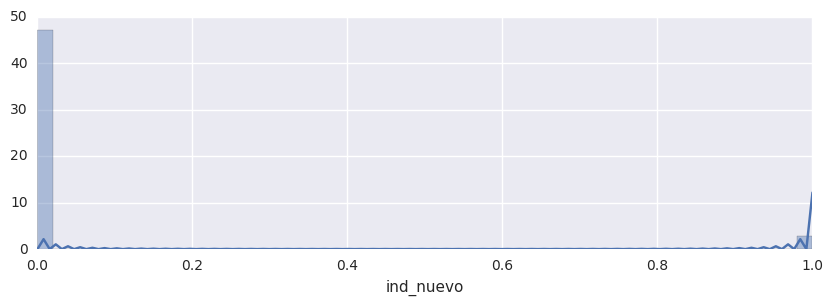

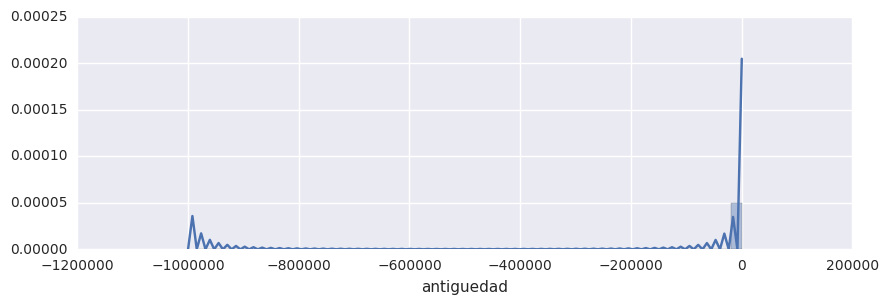

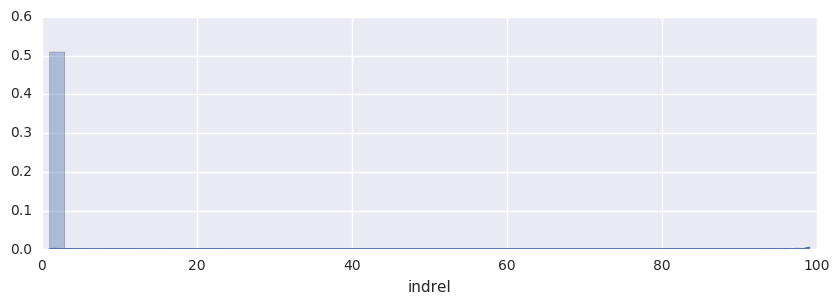

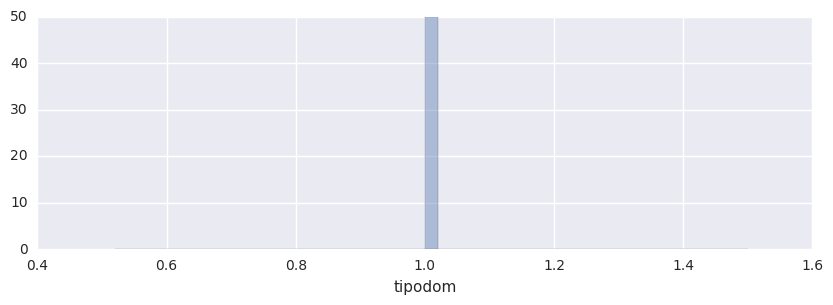

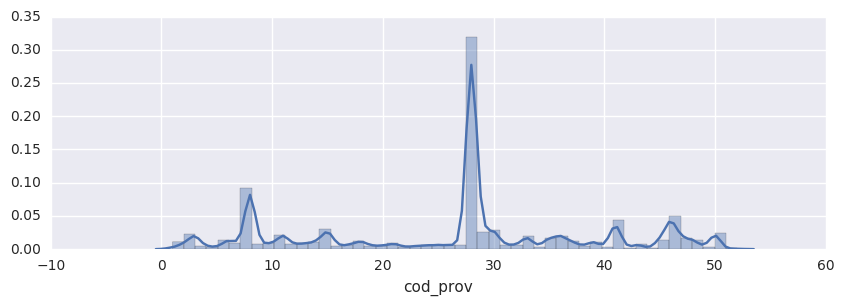

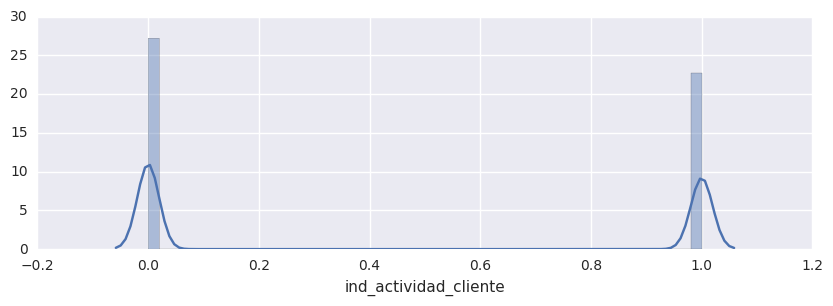

In [75]:
# separate numeric columns from object (categorical) columns
combined_num = combined.select_dtypes(exclude=['object'])
combined_cat = combined.select_dtypes(include=['object'])
print(combined_num.info())
print(combined_cat.info())

# the 'conyuemp' column is empty at 100000, so remove it
#combined_cat.drop('conyuemp', 1, inplace=True)

# tipodom doesn't seem to be useful, so I am going to drop it
#combined_num.drop('tipodom', 1, inplace=True)

# As 99% of 'ult_fec_cli_1t' information missing, so I am going to drop it
#combined_cat.drop('ult_fec_cli_1t', 1, inplace=True)

# as we have both cod_prov and nomprov, they represent the same thing. so drop nomprov
combined_cat.drop('nomprov', 1, inplace=True)

# check data distributions
col_names = combined_num.columns

for i in range(1,10):
    #fig, axes = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(8,3))
    if i != 3:
        fig = plt.figure(figsize=(10,3))
        sns.distplot(combined_num[col_names[i]].dropna(), bins=50)
        plt.show()

### Handle Missing Data

In [76]:
# check to see if any of the columns has missing values and how many for each column
# if there are missing values, we might need to impute/fill-in those missing values
no_nan_cols = []
for col, val in combined.isnull().any().items():
    if val == True:
        print("number of nan for column ", col, " is: ", combined[col].isnull().sum())
        pass
    else:
        no_nan_cols.append(col)
        pass
print("these columns has no nan values in them", no_nan_cols)

number of nan for column  ind_empleado  is:  27734
number of nan for column  pais_residencia  is:  27734
number of nan for column  sexo  is:  27809
number of nan for column  age  is:  27734
number of nan for column  fecha_alta  is:  27734
number of nan for column  ind_nuevo  is:  27734
number of nan for column  antiguedad  is:  27734
number of nan for column  indrel  is:  27734
number of nan for column  ult_fec_cli_1t  is:  14550448
number of nan for column  indrel_1mes  is:  149804
number of nan for column  tiprel_1mes  is:  149804
number of nan for column  indresi  is:  27734
number of nan for column  indext  is:  27734
number of nan for column  conyuemp  is:  14575012
number of nan for column  canal_entrada  is:  188207
number of nan for column  indfall  is:  27734
number of nan for column  tipodom  is:  27735
number of nan for column  cod_prov  is:  97587
number of nan for column  nomprov  is:  97587
number of nan for column  ind_actividad_cliente  is:  27734
number of nan for colu

#### For age, the missing are NA at the origin dataset
- replace nan with mean() value

In [77]:
# from the data distribution, we see that age has two modes. one is around ~20, while another one is around 45
age18less  = combined_num.loc[(combined_num.age >= 18) & (combined_num.age <= 30), 'age'].mean(skipna=True)
age90older = combined_num.loc[(combined_num.age > 30) & (combined_num.age <= 90), 'age'].mean(skipna=True)
print(age18less)
print(age90older)

combined_num.loc[combined_num.age < 18, 'age'] = age18less
combined_num.loc[combined_num.age > 90, 'age'] = age90older

print("Find the number of nan in age: ", combined_num.age.isnull().sum())

print("Mean of age is; ", int(combined_num.age.mean()))
combined_num.age.fillna(int(combined_num.age.mean(skipna=True)), inplace=True)

print("Check if any nan left: ", combined_num.age.isnull().sum())

23.81413816411713
50.05594176055697
Find the number of nan in age:  27734
Mean of age is;  39
Check if any nan left:  0


#### For fecha_alta (join date)
- Some entries don't have the date they joined the company. Just give them something in the middle of the pack

In [78]:
dates=combined_num.loc[:,"fecha_alta"].sort_values().reset_index()
median_date = int(np.median(dates.index.values))
print("median date is: ", median_date)
print("median value is: ", dates.loc[median_date,"fecha_alta"])
combined_num.loc[combined_num.fecha_alta.isnull(),"fecha_alta"] = dates.loc[median_date,"fecha_alta"]
#combined_num["fecha_alta"].describe()
print("Check for any nan left: ", combined_num.fecha_alta.isnull().sum())

median date is:  7288461
median value is:  2011-09-12 00:00:00
Check for any nan left:  0


In [79]:
print(median_date)
print(dates.loc[median_date,"fecha_alta"])

7288461
2011-09-12 00:00:00


#### for ind_nuevo (New customer), need to find out more info

In [80]:
# find out how many nan for ind_neuvo
print("The total nan in ind_nuevo is ", combined_num['ind_nuevo'].isnull().sum())

# for ind_nuevo: from graph, it is binary. let's find out using Counter()
print(Counter(combined_num['ind_nuevo'].dropna()))

The total nan in ind_nuevo is  27734
Counter({0.0: 13712094, 1.0: 837096})


#### From distribution graph, ind_nuevo is binary. >95% of values are 0.0, so we will try to find out their history

In [81]:
history = combined_num.loc[combined_num['ind_nuevo'].isnull(),:].groupby("ncodpers", sort=False).size()
print(max(history))

6


In [82]:
#### they all new customers. So set the value to 1
combined_num['ind_nuevo'].fillna(1.0, inplace=True)

# comnined_num.loc[combined_num['ind_neuvo'].isnull(), 'ind_neuvo'] = 1.0
print(combined_num['ind_nuevo'].isnull().any())

False


#### for antiguedad (antiquity or Seniority)

In [83]:
print("how many contains nan for antiquity: ", combined_num['antiguedad'].isnull().sum())

# find out the most common one
print(Counter(combined_num['antiguedad'].dropna()))

# it seems the number of nan in antiguedad is the same as ind_nuevo
# Probably the same people that we just determined were new customers. Double check
combined_num.loc[combined_num['antiguedad'].isnull(), 'ind_nuevo'].describe()

# yes, same people as they all nan. Let's give them minimum seniority. or 25% percentile
print(combined_num['antiguedad'].dropna().describe())
twenty_five = np.percentile(combined_num['antiguedad'].dropna(), 25)
print("twenty five is ", twenty_five)

# the 25 percentile is 14
combined_num['antiguedad'].fillna(twenty_five, inplace=True)
print("check if any nan left in antiguedad: ", combined_num['antiguedad'].isnull().any())


how many contains nan for antiquity:  27734
Counter({12.0: 246752, 21.0: 232718, 10.0: 216109, 9.0: 200929, 23.0: 193779, 33.0: 187062, 45.0: 182275, 8.0: 182038, 24.0: 172144, 44.0: 169368, 36.0: 166480, 20.0: 166158, 22.0: 164779, 34.0: 163516, 32.0: 162438, 35.0: 161115, 46.0: 155311, 43.0: 150514, 5.0: 146380, 11.0: 145138, 7.0: 143194, 16.0: 141009, 3.0: 137309, 47.0: 137268, 1.0: 136758, 0.0: 134613, 2.0: 134228, 19.0: 133833, 18.0: 133811, 4.0: 133566, 6.0: 132755, 14.0: 130008, 17.0: 129013, 13.0: 127110, 15.0: 125367, 31.0: 122725, 48.0: 121033, 26.0: 116494, 27.0: 113125, 25.0: 111611, 30.0: 109061, 28.0: 108237, 38.0: 108174, 29.0: 107734, 40.0: 105676, 41.0: 103402, 37.0: 102677, 39.0: 99856, 42.0: 97730, 49.0: 88648, 50.0: 88357, 52.0: 87968, 53.0: 84785, 51.0: 81649, 54.0: 81448, 165.0: 76806, 55.0: 75260, 164.0: 73230, 172.0: 71617, 162.0: 70749, 169.0: 68022, 166.0: 67974, 168.0: 67031, 170.0: 66230, 171.0: 63908, 163.0: 63085, 56.0: 62364, 161.0: 61517, 173.0: 60772, 1

#### now for 'indrel' column, which indicates
- 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

In [84]:
# find out how many rows are nan
print(combined_num['indrel'].isnull().sum())

# find out the most common count information
print(Counter(combined_num['indrel'].dropna()))

# fill in with most common one here
combined_num['indrel'].fillna(1.0, inplace=True)

print("Checking to see if the column has no more nan: ", combined_num['indrel'].isnull().any())

27734
Counter({1.0: 14522714, 99.0: 26476})
Checking to see if the column has no more nan:  False


#### now for 'indrel_1mes' column

In [85]:
# find out how many rows contain nan
print(combined_cat['indrel_1mes'].isnull().sum())

# find out the most common count info
print(Counter(combined_cat['indrel_1mes'].dropna()))
print(combined_cat.indrel_1mes.unique())

# fill in with the most common one here
combined_cat['indrel_1mes'].fillna(1.0, inplace=True)
print("Check to see if there is any nan left: ", combined_cat['indrel_1mes'].isnull().any())

149804
Counter({1.0: 8207172, '1.0': 4017746, '1': 2195328, '3.0': 1804, 3.0: 1436, '3': 1137, 'P': 874, '2': 483, '2.0': 479, 2.0: 355, '4.0': 143, 4.0: 93, '4': 70})
[1.0 nan 3.0 2.0 '1.0' '1' '3' '3.0' '2.0' '4.0' 'P' '4' 4.0 '2']
Check to see if there is any nan left:  False


#### for tipodom: (Addres type. 1, primary address)
- tipodom doesn't seem to be useful, so I am going to drop it, as it doesn't provide any useful information!

In [86]:
# find out how many in there
print(combined_num['tipodom'].isnull().sum())

# find out the most commone one
print(Counter(combined_num['tipodom'].dropna()))

# drop it
combined_num['tipodom'].fillna(1.0, inplace=True)
print("Check to see if there is still any nan left: ", combined_num['tipodom'].isnull().any())

27735
Counter({1.0: 14549189})
Check to see if there is still any nan left:  False


#### For conyuemp

In [87]:
print("Find out the num of nan: ", combined_cat.conyuemp.isnull().sum())

print("Find out count info: ", Counter(combined_cat.conyuemp.dropna()))


Find out the num of nan:  14575012
Find out count info:  Counter({'N': 1894, 'S': 18})


#### for cod_prov: provincial code for the address
- it seems that nom_prov is the name of the provincial. So they are redundant. We only need one of them.
- the nom_prov will be removed!!!

In [88]:
# find out how many are nan
print("number of nan is ", combined_num['cod_prov'].isnull().sum())

# find out how many 'nom_prov' is nan
#print("number of nan for nom_prov is: ", combined_cat['nomprov'].isnull().sum())

# to see if they are the same entries
train.loc[train['cod_prov'].isnull(), 'nomprov'].describe()
prov = train[['cod_prov', 'nomprov']]
#print(prov[prov['cod_prov'].isnull()])

# find out the unique values in cod_prov
print(combined_num['cod_prov'].unique())

# set the nan to 0 
combined_num['cod_prov'].fillna(0, inplace=True)
print(combined_num['cod_prov'].unique())

number of nan is  97587
[ 29.  13.  50.  45.  24.  20.  10.  17.  49.   8.  37.   9.  22.  31.   5.
  40.  27.  25.  28.   3.  42.  41.  39.   7.  47.  36.  46.  44.  15.  32.
  23.  16.  48.  12.  26.   2.   6.  30.  11.  nan   4.  19.  34.  35.  14.
  21.  18.  33.  38.  52.  43.   1.  51.]
[ 29.  13.  50.  45.  24.  20.  10.  17.  49.   8.  37.   9.  22.  31.   5.
  40.  27.  25.  28.   3.  42.  41.  39.   7.  47.  36.  46.  44.  15.  32.
  23.  16.  48.  12.  26.   2.   6.  30.  11.   0.   4.  19.  34.  35.  14.
  21.  18.  33.  38.  52.  43.   1.  51.]


#### ind_actividad_cliente  (Ind_activity customer)
- from the data distribution, it is binary

In [89]:
print("Total number of nan is: ", combined_num['ind_actividad_cliente'].isnull().sum())

print("Find out the most common ones: ", Counter(combined_num['ind_actividad_cliente'].dropna()))

# need more time and reading, but right now, I will use the median
#print("Median value is: ", combined_num['ind_actividad_cliente'].dropna().mean())

combined_num['ind_actividad_cliente'].fillna(2.0, inplace=True)

print("Find out the most common ones: ", Counter(combined_num['ind_actividad_cliente'].dropna()))


Total number of nan is:  27734
Find out the most common ones:  Counter({0.0: 7918666, 1.0: 6630524})
Find out the most common ones:  Counter({0.0: 7918666, 1.0: 6630524, 2.0: 27734})


#### renta (rental)
- Here is a feature that is missing a lot of values. Rather than just filling them in with a median, it's probably more accurate to break it down region by region. To that end, let's take a look at the median income by region.

In [90]:
print("Number of nan: ", combined_num['renta'].isnull().sum())

# from distribution, they are mostly close to the lower end
#print("The count info: ", combined_num['renta'].dropna().describe())

# group them by provincial code and find out the median of each one
#ave_rental = combined_num['renta'].dropna().groupby(combined_num['cod_prov']).describe()
ave_rental = combined_num['renta'].dropna().groupby(combined_num['cod_prov']).mean()
ave_rental = dict(ave_rental)
#print("The average rentals are: ", type(ave_rental))
print(ave_rental.keys())
print("\n")
print(ave_rental)

index = combined_num[combined_num['renta'].isnull()].index.tolist()
#print("The length of index is ", len(index))

# loop through is too slow, we have to do it python way
# rental_keys = ave_rental.keys()
#for idx in index:
#    prov_code = combined_num.ix[idx, 'cod_prov']
#    if prov_code in rental_keys:
#        combined_num.ix[idx, 'renta'] = ave_rental[prov_code]

# python way:
for pcode in ave_rental.keys():
    # fetch rows that are within the pcode and with 'renta' value is np.nan
    idx = combined_num.loc[combined_num.cod_prov.isin([pcode]) & combined_num.renta.isnull(), 'renta'].index.tolist()
    if idx:
        #print(idx)
        combined_num.ix[idx, 'renta'] = ave_rental[pcode]
    
print("Number of nan: ", combined_num['renta'].isnull().sum())
#print(combined_num[['cod_prov', 'renta']],)


Number of nan:  3022340
dict_keys([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0])


{0.0: 190864.28134387353, 1.0: 116454.21824999999, 2.0: 83059.639880275121, 3.0: 87347.808423990966, 4.0: 85374.23584159567, 5.0: 76816.518459868807, 6.0: 72176.18582748514, 7.0: 171995.86848114064, 8.0: 164672.39357774809, 9.0: 97878.796620592184, 10.0: 75372.170251322314, 11.0: 98648.098741735899, 12.0: 79174.239231086744, 13.0: 69896.499221334176, 14.0: 85622.935385531295, 15.0: 112788.86299594035, 16.0: 69949.635891681086, 17.0: 144340.73909940803, 18.0: 96553.136598167126, 19.0: 95550.728265982965, 20.0: 139632.71175824184, 21.0: 76687.208433018008, 22.0: 89229.944358405774, 23.0: 77132.018859586417, 24.0: 93387.127306748385, 25.0: 81230.193

-The next columns with missing data I'll look at are features, which are just a boolean indicator as to whether or not that product was owned that month. Starting with ind_nomina_ult1..

In [91]:
# for ind_nomina_ult1, This column is not available at the test dataset, so I will update training data only
print("The number of missing data is: ", train.ind_nomina_ult1.isnull().sum())

print("Find out how many unique values in this column: ", Counter(train.ind_nomina_ult1.dropna()))

# I could try to fill in missing values for products by looking at previous months, 
# but since it's such a small number of values for now I'll take the cheap way out, using most common one ==> 0.0
train.loc[train.ind_nomina_ult1.isnull(), 'ind_nomina_ult1'] = 0.0

print("Check to see if there is any nan left: ", train.ind_nomina_ult1.isnull().sum())

The number of missing data is:  16063
Find out how many unique values in this column:  Counter({0.0: 12885285, 1.0: 745961})
Check to see if there is any nan left:  0


- The same could be true for ind_nom_pens_ult1

In [92]:
print("The number of missing values is: ", train.ind_nom_pens_ult1.isnull().sum())

print("The unique cout information: ", Counter(train.ind_nom_pens_ult1.dropna()))

train.loc[train.ind_nom_pens_ult1.isnull(), 'ind_nom_pens_ult1'] = 0

print("Check to see if any nan left: ", train.ind_nom_pens_ult1.isnull().sum())

The number of missing values is:  16063
The unique cout information:  Counter({0.0: 12821161, 1.0: 810085})
Check to see if any nan left:  0


### For categorical columns:
- based on that and the definitions of each variable, I will fill the empty strings either with the most common value or create an unknown category based on what I think makes more sense.
- For the most part, entries with NA will be converted to an unknown category.

#### For ind_empleado (employed or employment)
- fill-in with the most common one

In [93]:
print("The number of missing values is: ", combined_cat.ind_empleado.isnull().sum())

print("Find out the count information: ", Counter(combined_cat.ind_empleado.dropna()))

# fill-in with the most common one, that is 'N'
combined_cat.loc[combined_cat.ind_empleado.isnull(), 'ind_empleado'] = 'N'

print("Check to see if there is any nan left: ", combined_cat.ind_empleado.isnull().sum())

The number of missing values is:  27734
Find out the count information:  Counter({'N': 14540073, 'B': 3784, 'F': 2675, 'A': 2640, 'S': 18})
Check to see if there is any nan left:  0


#### For pais_residencia (Country of residency)
- fill-in with the most common one

In [94]:
print("Find the number of missing values: ", combined_cat.pais_residencia.isnull().sum())

print("Find the count information: ", Counter(combined_cat.pais_residencia.dropna()))

# fill-in with the most common one that is 'ES'
combined_cat.loc[combined_cat.pais_residencia.isnull(), 'pais_residencia'] = 'ES'

print("Check to see if there is any nan left: ", combined_cat.pais_residencia.isnull().sum())

Find the number of missing values:  27734
Find the count information:  Counter({'ES': 14479329, 'FR': 5472, 'AR': 5123, 'DE': 4906, 'GB': 4891, 'US': 3882, 'CO': 3737, 'IT': 3126, 'RO': 3106, 'MX': 2729, 'BR': 2492, 'VE': 2467, 'EC': 2299, 'CH': 2119, 'BE': 1619, 'BO': 1607, 'PY': 1517, 'PT': 1509, 'CL': 1048, 'PE': 954, 'RU': 814, 'NL': 804, 'CU': 802, 'SE': 640, 'PL': 637, 'CN': 596, 'UY': 540, 'UA': 522, 'AT': 505, 'BG': 504, 'CA': 473, 'DO': 450, 'AU': 449, 'IL': 438, 'IE': 434, 'MA': 420, 'FI': 366, 'HN': 300, 'GR': 258, 'JP': 254, 'DK': 240, 'AE': 234, 'NG': 226, 'IN': 198, 'CR': 156, 'NO': 144, 'GT': 138, 'LU': 132, 'ZA': 126, 'GQ': 126, 'SG': 123, 'AD': 118, 'SV': 108, 'TH': 108, 'CZ': 108, 'BY': 108, 'PR': 106, 'MD': 102, 'KR': 101, 'DZ': 92, 'SK': 90, 'CM': 90, 'PK': 90, 'SA': 84, 'PA': 82, 'KE': 76, 'HR': 72, 'EG': 72, 'AO': 72, 'SN': 72, 'TR': 66, 'NI': 66, 'QA': 56, 'NZ': 54, 'GA': 54, 'MK': 54, 'MR': 54, 'GN': 54, 'HK': 54, 'CI': 54, 'LT': 48, 'EE': 48, 'HU': 41, 'RS': 36

#### For sexo
- use unknown category

In [95]:
print("Find how many is nan: ", combined_cat.sexo.isnull().sum())

print("Get the count information\\\: ", Counter(combined_cat.sexo.dropna()))

combined_cat.loc[combined_cat.sexo.isnull(), 'sexo'] = 'U'

print("Check if any nan left:  ", combined_cat.sexo.isnull().sum())

Find how many is nan:  27809
Get the count information\\:  Counter({'V': 7928767, 'H': 6620348})
Check if any nan left:   0


#### for ult_fec_cli_1t

In [96]:
print("Find how many nan in ult_fec_cli_1t: ", combined_cat.ult_fec_cli_1t.isnull().sum())

print("Find the count information: ", Counter(combined_cat.ult_fec_cli_1t.dropna()))

# this is a date information and no most common one, we might have to set it with an unknown
# As 99% of data miss this information. I am going to drop it!

Find how many nan in ult_fec_cli_1t:  14550448
Find the count information:  Counter({'2015-12-24': 763, '2015-12-28': 521, '2015-07-09': 443, '2015-07-06': 405, '2015-07-01': 401, '2015-07-21': 391, '2015-07-07': 340, '2015-07-17': 330, '2015-07-10': 320, '2015-07-28': 311, '2015-07-24': 299, '2015-07-20': 295, '2015-07-22': 275, '2015-07-15': 273, '2015-07-03': 262, '2015-07-29': 255, '2015-07-13': 229, '2015-07-30': 224, '2015-12-21': 206, '2015-07-23': 206, '2015-07-27': 203, '2015-07-14': 196, '2015-07-08': 175, '2015-12-17': 172, '2016-01-19': 169, '2016-01-05': 167, '2015-07-02': 166, '2015-12-16': 158, '2015-07-16': 147, '2015-12-18': 139, '2016-06-01': 138, '2016-06-10': 133, '2016-04-01': 132, '2015-10-26': 131, '2016-02-15': 129, '2015-10-05': 129, '2015-11-02': 128, '2016-05-26': 128, '2016-05-02': 128, '2015-10-28': 125, '2016-05-24': 124, '2016-01-13': 122, '2016-02-01': 121, '2015-10-01': 115, '2015-09-14': 114, '2015-10-15': 113, '2016-01-27': 112, '2015-10-07': 112, '20

#### For indfall
- use the most common one 'N'

In [97]:
print("Find how many nan in this column: ", combined_cat.indfall.isnull().sum())

print("Find the most common one: ", Counter(combined_cat.indfall.dropna()))

# fill-in with the most common one
combined_cat.loc[combined_cat.indfall.isnull(), 'indfall'] = 'N'

print("Check to see if any nan left: ", combined_cat.indfall.isnull().sum())

Find how many nan in this column:  27734
Find the most common one:  Counter({'N': 14512028, 'S': 37162})
Check to see if any nan left:  0


#### For tiprel_1mes

In [98]:
print("Find out how many nan in this column: ", combined_cat.tiprel_1mes.isnull().sum())

print("Find out the most common one; ", Counter(combined_cat.tiprel_1mes.dropna()))

# fill-in with an unknown 'U'
combined_cat.loc[combined_cat.tiprel_1mes.isnull(), 'tiprel_1mes'] = 'U'

print("Check to see if any nan left: ", combined_cat.tiprel_1mes.isnull().sum())

Find out how many nan in this column:  149804
Find out the most common one;  Counter({'I': 7840818, 'A': 6580745, 'P': 4683, 'R': 870, 'N': 4})
Check to see if any nan left:  0


#### For indresi
- fill-in with the most commone one, 'S'

In [99]:
print("Find how many nan: ", combined_cat.indresi.isnull().sum())

print("Get the count information: ", Counter(combined_cat.indresi.dropna()))

combined_cat.loc[combined_cat.indresi.isnull(), 'indresi'] = 'S'

print("Check to see if any nan left: ", combined_cat.indresi.isnull().sum())

Find how many nan:  27734
Get the count information:  Counter({'S': 14479331, 'N': 69859})
Check to see if any nan left:  0


#### For indext
- fill-in with the most common one

In [100]:
print("Find out how many nan in this column: ", combined_cat.indext.isnull().sum())

print("Get count information: ", Counter(combined_cat.indext.dropna()))

combined_cat.loc[combined_cat.indext.isnull(), 'indext'] = 'N'

print("Check to see if any nan left: ", combined_cat.indext.isnull().sum())

Find out how many nan in this column:  27734
Get count information:  Counter({'N': 13858387, 'S': 690803})
Check to see if any nan left:  0


#### For canal_entrada (input channel)

In [101]:
print("Find how many nans: ", combined_cat.canal_entrada.isnull().sum())

print("Find the most common one: ", Counter(combined_cat.canal_entrada.dropna()))

# fill-in with the most common one, 'KHE'
combined_cat.loc[combined_cat.canal_entrada.isnull(), 'canal_entrada'] = 'KHE'

print("Check to see if any nan left: ", combined_cat.canal_entrada.isnull().sum())

Find how many nans:  188207
Find the most common one:  Counter({'KHE': 4306935, 'KAT': 3474042, 'KFC': 3299057, 'KHQ': 666008, 'KFA': 435322, 'KHK': 258002, 'KHM': 217308, 'KHN': 134739, 'KHD': 124281, 'KAS': 91805, 'RED': 81935, 'KAG': 78958, 'KAY': 71791, 'KAA': 70951, 'KAB': 66395, 'KAE': 54057, 'KCC': 52427, 'KBZ': 49455, 'KHL': 48076, 'KFD': 47412, 'KAI': 40127, 'KEY': 37419, 'KAW': 36481, 'KAR': 34822, 'KAZ': 34325, 'KAF': 32472, '007': 31260, '013': 28798, 'KCI': 28323, 'KAH': 26463, 'KAJ': 25950, 'KCH': 25741, 'KHF': 22051, 'KAQ': 19218, 'KHC': 17548, 'KAP': 15947, 'KAM': 12027, 'KAD': 11342, 'KHO': 10517, 'KFP': 10114, 'KGX': 10106, 'KEJ': 9885, 'KGV': 9534, 'KFT': 8592, 'KDR': 8587, 'KAC': 8181, 'KAL': 8089, 'KBO': 7878, 'KBH': 7678, 'KFG': 7247, 'KFS': 7170, 'KAO': 7127, 'KFJ': 7080, 'KES': 6275, 'KEW': 6046, 'KFF': 5903, 'KCG': 5736, 'KCB': 5523, 'KFU': 5256, 'KEN': 5245, 'KFN': 4827, 'KCL': 4466, 'KBQ': 4446, 'KGY': 4413, 'KFK': 4184, 'KFL': 4060, 'KBF': 4022, 'KCD': 3499,

#### For segmento (segment)

In [102]:
print("Find how many nans: ", combined_cat.segmento.isnull().sum())

print("Find the most common one: ", Counter(combined_cat.segmento.dropna()))

# fill-in with the most common one, as the new costomers are unlikely to be at the top
combined_cat.loc[combined_cat.segmento.isnull(), 'segmento'] = 'UNIVERSITARIO'

print("Check to see if any nans left: ", combined_cat.segmento.isnull().sum())

Find how many nans:  191616
Find the most common one:  Counter({'02 - PARTICULARES': 8505598, '03 - UNIVERSITARIO': 5281607, '01 - TOP': 598103})
Check to see if any nans left:  0


In [103]:
# now left see if any nan left in the entire dataset
#del combined

print(combined_num.isnull().any())
print(combined_cat.isnull().any())
#combined = pd.concat([combined_num, combined_cat])
#combined.isnull().any()

fecha_dato               False
ncodpers                 False
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
tipodom                  False
cod_prov                 False
ind_actividad_cliente    False
renta                    False
dtype: bool
ind_empleado       False
pais_residencia    False
sexo               False
ult_fec_cli_1t      True
indrel_1mes        False
tiprel_1mes        False
indresi            False
indext             False
conyuemp            True
canal_entrada      False
indfall            False
segmento           False
dtype: bool


In [104]:
print("nan in train age:  ", train.age.isnull().sum())
print("nan in test age:  ", test.age.isnull().sum())
print("nan in trainX age:  ", trainX.age.isnull().sum())
print("nan in combined age:  ", combined.age.isnull().sum())
print("nan in combined_num age:  ", combined_num.age.isnull().sum())

nan in train age:   0
nan in test age:   0
nan in trainX age:   0
nan in combined age:   27734
nan in combined_num age:   0


#### Now for the remaining 24 columns that are missing in test dataset

In [105]:
for col in trainZ.columns:
    print("The count information for ", col, ' is ', Counter(trainZ[col].dropna()))

The count information for  ind_ahor_fin_ult1  is  Counter({0: 13645913, 1: 1396})
The count information for  ind_aval_fin_ult1  is  Counter({0: 13646993, 1: 316})
The count information for  ind_cco_fin_ult1  is  Counter({1: 8945588, 0: 4701721})
The count information for  ind_cder_fin_ult1  is  Counter({0: 13641933, 1: 5376})
The count information for  ind_cno_fin_ult1  is  Counter({0: 12543689, 1: 1103620})
The count information for  ind_ctju_fin_ult1  is  Counter({0: 13518012, 1: 129297})
The count information for  ind_ctma_fin_ult1  is  Counter({0: 13514567, 1: 132742})
The count information for  ind_ctop_fin_ult1  is  Counter({0: 11886693, 1: 1760616})
The count information for  ind_ctpp_fin_ult1  is  Counter({0: 13056301, 1: 591008})
The count information for  ind_deco_fin_ult1  is  Counter({0: 13623034, 1: 24275})
The count information for  ind_deme_fin_ult1  is  Counter({0: 13624641, 1: 22668})
The count information for  ind_dela_fin_ult1  is  Counter({0: 13060928, 1: 586381})
T

### The targets (Labels)
- here trainZ is really the targets

In [106]:
target_cols = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1',
               'ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1',
               'ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1',
               'ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1',
               'ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']
print(len(target_cols))
target_cols = target_cols[2:]
print(len(target_cols))

24
22


### Need to find out the number of entries for dates: 2015-05-28, 2015-06-28, 2016-05-28 and 2016-06-28

In [37]:
print("Train data info: ", train.info())
print("\n")
print("Test data info: ", test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
fecha_dato               object
ncodpers                 int64
ind_empleado             object
pais_residencia          object
sexo                     object
age                      object
fecha_alta               object
ind_nuevo                float64
antiguedad               object
indrel                   float64
ult_fec_cli_1t           object
indrel_1mes              object
tiprel_1mes              object
indresi                  object
indext                   object
conyuemp                 object
canal_entrada            object
indfall                  object
tipodom                  float64
cod_prov                 float64
nomprov                  object
ind_actividad_cliente    float64
renta                    float64
segmento                 object
ind_ahor_fin_ult1        int64
ind_aval_fin_ult1        int64
ind_cco_fin_ult1         int64
ind_cder_fin_ult1  

In [38]:
print(train['fecha_dato'].unique())
print(Counter(train['fecha_dato']))

['2015-01-28' '2015-02-28' '2015-03-28' '2015-04-28' '2015-05-28'
 '2015-06-28' '2015-07-28' '2015-08-28' '2015-09-28' '2015-10-28'
 '2015-11-28' '2015-12-28' '2016-01-28' '2016-02-28' '2016-03-28'
 '2016-04-28' '2016-05-28']
Counter({'2016-05-28': 931453, '2016-04-28': 928274, '2016-03-28': 925076, '2016-02-28': 920904, '2016-01-28': 916269, '2015-12-28': 912021, '2015-11-28': 906109, '2015-10-28': 892251, '2015-09-28': 865440, '2015-08-28': 843201, '2015-07-28': 829817, '2015-06-28': 632110, '2015-05-28': 631957, '2015-04-28': 630367, '2015-03-28': 629209, '2015-02-28': 627394, '2015-01-28': 625457})


In [39]:
print(test['fecha_dato'].unique())
print(Counter(test['fecha_dato']))

['2016-06-28']
Counter({'2016-06-28': 929615})


In [40]:
# use only the four months as specified by breakfastpirate #
dates = ['2015-05-28', '2015-06-28', '2016-05-28', '2016-06-28']
iter_csv = pd.read_csv("../../input/train_ver2.csv", chunksize=100000, header=0)
#train2 = pd.concat([chunk[chunk['fecha_dato'].any() in dates,] for chunk in iter_csv])

train2 = pd.DataFrame([])
for chunks in iter_csv:
    #print(type(chunks))
    if chunks['fecha_dato'].any() in dates:
        train2 = pd.concat([train2, chunks])

In [41]:
train2.info(memory_usage=True)
train.info(memory_usage=True)
test.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047309 entries, 0 to 47308
Data columns (total 48 columns):
fecha_dato               object
ncodpers                 int64
ind_empleado             object
pais_residencia          object
sexo                     object
age                      object
fecha_alta               object
ind_nuevo                float64
antiguedad               object
indrel                   float64
ult_fec_cli_1t           object
indrel_1mes              object
tiprel_1mes              object
indresi                  object
indext                   object
conyuemp                 object
canal_entrada            object
indfall                  object
tipodom                  float64
cod_prov                 float64
nomprov                  object
ind_actividad_cliente    float64
renta                    float64
segmento                 object
ind_ahor_fin_ult1        int64
ind_aval_fin_ult1        int64
ind_cco_fin_ult1         int64
ind_cder_fin_ult1      

In [42]:
print(Counter(train2['fecha_dato']))
print(Counter(train['fecha_dato']))

Counter({'2016-05-28': 847309, '2015-06-28': 632110, '2015-05-28': 544384, '2015-07-28': 23506})
Counter({'2016-05-28': 931453, '2016-04-28': 928274, '2016-03-28': 925076, '2016-02-28': 920904, '2016-01-28': 916269, '2015-12-28': 912021, '2015-11-28': 906109, '2015-10-28': 892251, '2015-09-28': 865440, '2015-08-28': 843201, '2015-07-28': 829817, '2015-06-28': 632110, '2015-05-28': 631957, '2015-04-28': 630367, '2015-03-28': 629209, '2015-02-28': 627394, '2015-01-28': 625457})


In [43]:
# use only the four months as specified by breakfastpirate #
dates = ['2015-05-28', '2015-06-28', '2016-05-28', '2016-06-28']
#train3 = pd.read_csv("../../input/train_ver2.csv").filter(lambda x: x['fecha_dato'] in dates)

In [45]:
dates = ['2015-05-28', '2015-06-28', '2016-05-28', '2016-06-28']
train4 = train[train.fecha_dato.isin(dates)]
print(type(train4))

train4.to_csv('filtered_train_dataset.csv', index=False)
print(Counter(train4['fecha_dato']))

<class 'pandas.core.frame.DataFrame'>
Counter({'2016-05-28': 931453, '2015-06-28': 632110, '2015-05-28': 631957})
